In [176]:
import os
import sys
import pickle
import jieba
import json
import operator
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from datetime import datetime
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

font_path = 'msjh.ttc'
font = font_manager.FontProperties(fname='msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

### check system encoding

In [11]:
sys.getfilesystemencoding()


'utf-8'

In [2]:
jieba.set_dictionary('../jieba_data/dict.txt.big')
jieba.load_userdict('../jieba_data/userdict.txt')
stopwords = []
with open('../jieba_data/stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines():
        stopwords.append(each.strip())
    stopwords.append(' ')

stopwords[:10]

Building prefix dict from C:\Users\GIGABYTE\fin_class\jieba_data\dict.txt.big ...
Dumping model to file cache C:\Users\GIGABYTE\AppData\Local\Temp\jieba.u76dcdccef8b36c29aab3e633e439e35d.cache
Loading model cost 2.090 seconds.
Prefix dict has been built succesfully.


['\ufeff', '', '$', '0', '1', '2', '3', '4', '5', '6']

## 將爬下來的新聞從pickle 取出並且存成list

contents = [news['content'] for news in data]
 
contents = []
for news in data :
    contents.append(news['content'])
方便我自己觀察

In [12]:
with open('../crawler/data/free_news.pkl', 'rb') as pkl:
    data = pickle.load(pkl)
    
data = data[::-1]
contents = []
for news in data :
    contents.append(news['content'])

### encoding = utf-8-sig 是為了避免一開始出現\ufeff的情況 (詳情自 https://ithelp.ithome.com.tw/articles/10187778 )

In [220]:
names = []
with open('../data/names.txt', 'r', encoding='utf-8-sig') as txt:
    names = txt.read().split('\n')
    
events = []
with open('../data/events.txt', 'r', encoding='utf-8-sig') as txt:
    events = txt.read().split('\n')

## user_pc 改成 user_define_list 表示可以自行使用自定義的清洗list

把亂碼或者不重要英文字用空格取代

In [31]:
def remove_punctuation(content_string, user_define_list=False):
    if(user_define_list):
        punctuation = user_define_list
    else:
        punctuation=list("!@#$%^&*()_+=-[]`~'\"|/\\abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.;{}\r\xa0\u3000、，。「」！？；：<>")
        
    for word in punctuation:
        content_string = content_string.replace(word, " ")
    return(content_string)

def remove_stopwords_from_dict(word_dict, stopwords):
    for w in stopwords:
        word_dict.pop(w, word_dict)
    return word_dict

def lcut_to_dict(lcut):
    word_dict = dict(Counter(lcut))
#     word_dict.pop(' ')
    return(remove_stopwords_from_dict(word_dict, stopwords))

def sort_dict_by_values(d):
    return(sorted(d.items(), key=lambda x: x[1], reverse=True))

跑過所有 data_contents 且用 jieba.lcut 切成詞彙做成List 
且用 remove_punctuation 來刪除不必要的符號以及英文

dictionary.pop() 用法 https://www.programiz.com/python-programming/methods/dictionary/pop
簡單來說就是把字典中出現的key(包含其value) 給刪除

In [32]:
def remove_stopwords_from_dict(word_dict, stopwords):
    for word in stopwords:
        word_dict.pop(word, word_dict)
    return word_dict

lcut to dict 在算出lcut (data_content 被詞彙切割(jieba)後的list) 的數量(用counter) 再返回成dict 存成 word_dict

且調用 remove_stopwords_from_dict 來清洗 word_dict中沒有意義的詞彙

In [33]:
def lcut_to_dict(lcut):
    word_dict = dict(Counter(lcut))
#     word_dict.pop(' ')
    return(remove_stopwords_from_dict(word_dict, stopwords))


sort_dict_by_values 使用 sorted 來將dict以value大小來排序(reverse = True 表示以降次排序) (在此意思為出現次數多寡排序) 
sorted 用法 http://www.runoob.com/python/python-func-sorted.html

In [34]:
def sort_dict_by_values(clean_dict):
    return(sorted(clean_dict.items(), key=lambda x: x[1], reverse=True))

filter and lambda 用法 https://openhome.cc/Gossip/CodeData/PythonTutorial/FunctionalProgrammingPy3.html

In [48]:
def news_containing_keyword(keyword, news_list):
    return list(filter(lambda news: keyword in news, news_list))  

def data_containing_keyword(keyword, data):
    return list(filter(lambda news: keyword in news['cutted_dict'].keys(), data))

def news_containing_keywords(keywords, news_list):
    news = news_list
    for keyword in keywords:
        news = news_containing_keyword(keyword, news)
        
    return news

### 將每一則新聞 清洗並且統計出有用詞彙後 新增到data中 (以一個dict形式)

In [36]:
# add cutted dict to each news
for i in range(len(data)):
    current_content = data[i]['content']
    current_cutted = jieba.lcut(remove_punctuation(current_content))
    data[i]['cutted_dict'] = lcut_to_dict(current_cutted)

In [37]:
data[0]['cutted_dict']  ### 表示為第一則新聞的詞彙統計次數

{'◎': 1,
 '易思安': 1,
 '台北': 4,
 '正迎': 1,
 '一個': 3,
 '或將': 1,
 '危疑': 1,
 '震撼': 1,
 '未來': 3,
 '中華人民共和國': 2,
 '領導階層': 1,
 '正': 1,
 '持續': 1,
 '增強': 1,
 '核武': 9,
 '戰力': 2,
 '中華民國': 2,
 '台灣': 20,
 '美國': 17,
 '發動': 3,
 '攻擊': 3,
 '國防': 1,
 '情報局': 1,
 '2019': 2,
 '中國軍力': 1,
 '報告': 1,
 '北京當局': 3,
 '研發': 3,
 '一種': 2,
 '核': 4,
 '匿': 1,
 '蹤': 1,
 '轟炸機': 2,
 '新型': 1,
 '服役': 1,
 '它將': 1,
 '中國': 17,
 '首度': 1,
 '擁有': 1,
 '可恃': 1,
 '陸': 1,
 '海': 1,
 '空': 1,
 '三位一體': 1,
 '投射': 3,
 '系統': 3,
 '擴張': 3,
 '破壞性': 2,
 '危險': 1,
 '儲備': 1,
 '核彈頭': 4,
 '愈': 2,
 '將其': 1,
 '用來': 1,
 '一場': 2,
 '預謀': 1,
 '日後': 1,
 '危機': 4,
 '爆發': 3,
 '陷入': 1,
 '混亂': 1,
 '時': 2,
 '失控': 2,
 '可能性': 2,
 '大': 1,
 '分散': 2,
 '發生': 1,
 '可怕': 1,
 '誤判': 1,
 '不測': 1,
 '機率': 1,
 '會': 7,
 '向上': 1,
 '攀升': 1,
 '箇中': 1,
 '原因': 2,
 '不妨': 1,
 '試著': 1,
 '想像': 1,
 '一段時間': 1,
 '情勢': 3,
 '高度': 1,
 '緊張': 2,
 '配置': 1,
 '戰略': 3,
 '武力': 1,
 '置於': 1,
 '行駛': 1,
 '內陸': 1,
 '飛彈': 3,
 '發射': 2,
 '車上': 1,
 '位於': 1,
 '潛艦': 1,
 '井內': 1,
 '潛艦會': 1,
 '太平洋': 1,
 '冰冷': 1,
 '

# Coshow

In [229]:
def get_coshow(contents):
    coshow_dict = {}
    cat_content = ' '.join(contents[:100])
    clean_content = remove_punctuation(cat_content)
    cut_content = jieba.lcut(clean_content)
    cut_content = list(filter(lambda x: x!=' ', cut_content))  ### 只取非 ' ' 的詞彙
    for i in range(len(cut_content)-1):
        wcw = cut_content[i] + cut_content[i+1]
    #     print(wcw)
        try:
            coshow_dict[wcw] = coshow_dict[wcw] + 1
        except:
            coshow_dict[wcw] = 1

    sdbv = sort_dict_by_values(coshow_dict)  ## 將dict 用降階方式旁續
    return sdbv

## Count words

In [39]:
def get_cutted_dict(list_of_news):
    cat = ' '.join(list_of_news)   ### join retrun not a list 
    cat = remove_punctuation(cat)   ### 刪除無異議字符號
    cutted = jieba.lcut(cat)  ### 以詞彙切割成lsit 
    return lcut_to_dict(cutted)

def first_n_words(cutted_dict, n, word_len=2, to=1000):
    sdbv = sort_dict_by_values(cutted_dict)
    return list(filter(lambda x: len(x[0])>=word_len and len(x[0])<=to, sdbv))[:n]

python join sourse http://www.runoob.com/python/att-string-join.html

In [40]:
cutted_dict = get_cutted_dict(contents[:1000])
high_freq_pair = first_n_words(cutted_dict, 20)
high_freq_pair   ### return a list 

[('台灣', 184),
 ('中國', 115),
 ('美國', 58),
 ('日本', 50),
 ('台北', 42),
 ('記者', 40),
 ('報導', 40),
 ('二二八', 33),
 ('指出', 32),
 ('台日', 32),
 ('和平', 29),
 ('提出', 26),
 ('民進黨', 25),
 ('國民黨', 25),
 ('議題', 23),
 ('媒體', 23),
 ('關係', 22),
 ('蔡總統', 22),
 ('昨天', 22),
 ('國家', 21)]

In [41]:
cutted_dict = get_cutted_dict(contents)

In [42]:
# 可能人名
possible_name = first_n_words(cutted_dict, 1000, 3, 3)

In [43]:
# 可能事件
possible_events = first_n_words(cutted_dict, 200, 4)

In [44]:
wc = WordCloud(max_font_size=40,
               background_color="white",
               colormap='Set2',
               font_path=font_path,
               width=1000, height=300,
              max_words=1000)

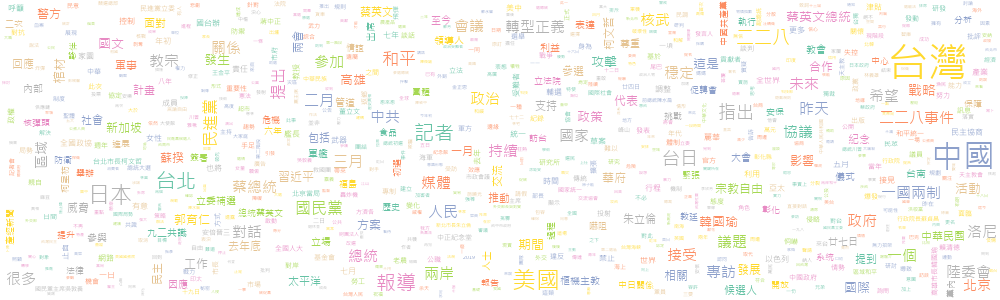

In [45]:
cutted_dict = get_cutted_dict(contents)
high_freq_pair = first_n_words(cutted_dict, 10000)

wc.generate_from_frequencies({word: freq for (word, freq) in high_freq_pair}).to_image()

In [46]:
def get_wordcloud_of_keywords(keywords, list_of_news, image_path=False):
    if type(keywords) == str:
        keywords = [keywords]
    
    if image_path:
        coloring = np.array(Image.open(os.path.join(image_path)))
        color_func = ImageColorGenerator(coloring)
        wc = WordCloud(max_font_size=30,
                       background_color="white",
                       mask=coloring,
                       color_func=color_func,
                       font_path=font_path,
                       width=1000, height=1000,
                      max_words=10000)
    else:
        wc = WordCloud(max_font_size=30,
                       background_color="white",
                       colormap='Set2',
                       font_path=font_path,
                       width=1000, height=300,
                      max_words=1000)
    
    keyword_news = news_containing_keywords(keywords, list_of_news)
    keyword_dict = get_cutted_dict(keyword_news)
    print(len(keyword_dict))
    im = wc.generate_from_frequencies(keyword_dict)
    return im

## 熱門政治人物文字雲

1980


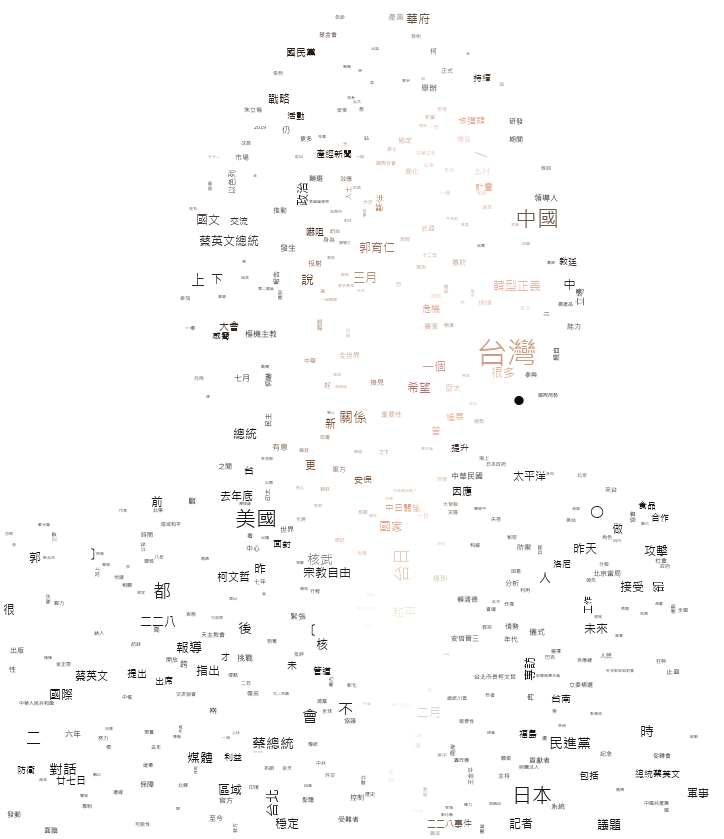

In [49]:
# 蔡英文
ten_wc = get_wordcloud_of_keywords('蔡英文', contents, '../politicians/ten.png')
ten_wc.to_file('../politicians/tenwc.png')
ten_wc.to_image()

### 查看關鍵字

In [50]:
news_containing_ten = news_containing_keyword('蔡英文', contents)
ten_dict = get_cutted_dict(news_containing_ten)
first_n_words(ten_dict, 10)

[('台灣', 123),
 ('中國', 59),
 ('美國', 52),
 ('日本', 48),
 ('台日', 32),
 ('台北', 24),
 ('蔡總統', 22),
 ('民進黨', 22),
 ('對話', 21),
 ('關係', 20)]

940


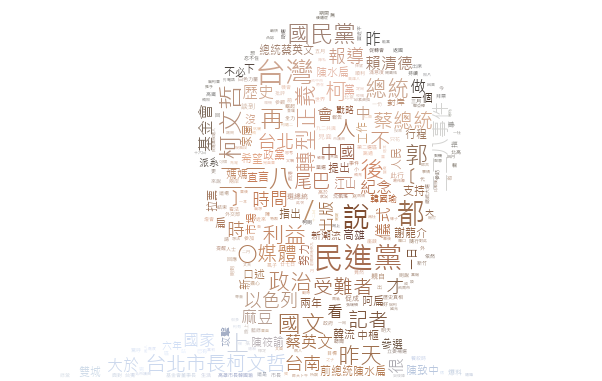

In [51]:
# 柯文哲
kp_wc = get_wordcloud_of_keywords('柯文哲', contents, image_path='../politicians/kp.png')
kp_wc.to_file('../politicians/kpwc.png')
kp_wc.to_image()

In [52]:
news_containing_kp = news_containing_keyword('柯文哲', contents)
kp_dict = get_cutted_dict(news_containing_kp)
first_n_words(kp_dict, 10)

[('民進黨', 15),
 ('台灣', 14),
 ('柯文哲', 10),
 ('二二八', 10),
 ('國文', 9),
 ('國民黨', 8),
 ('總統', 7),
 ('政治', 7),
 ('昨天', 7),
 ('轉型正義', 7)]

1262


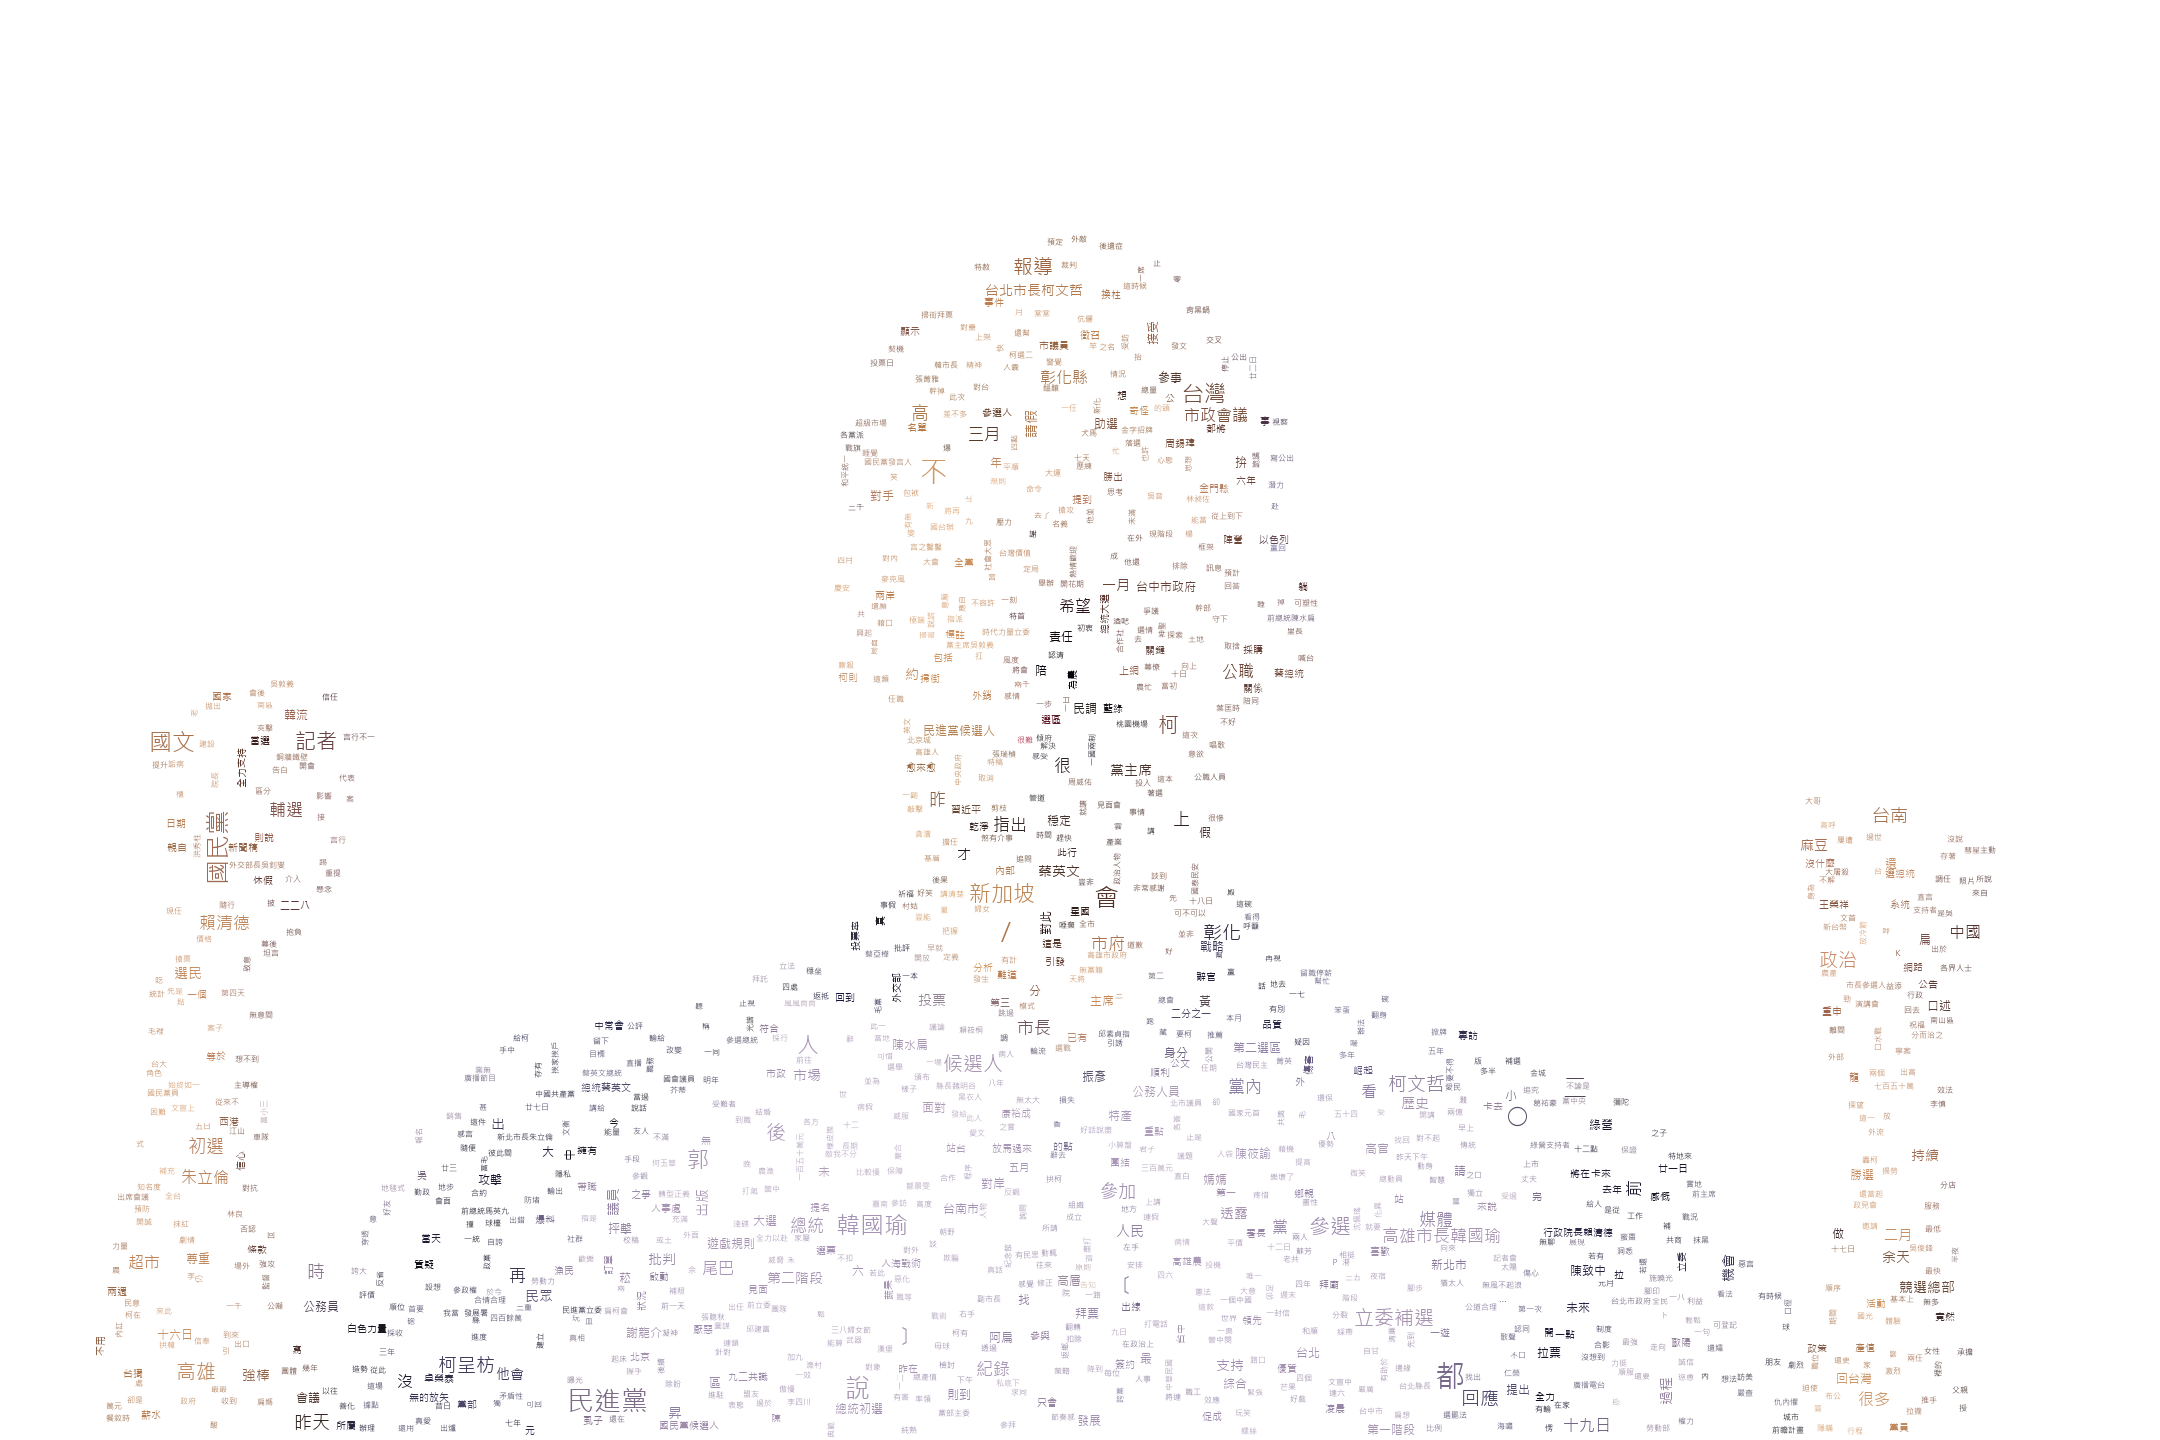

In [53]:
# 韓國瑜
han_wc = get_wordcloud_of_keywords('韓國瑜', contents, '../politicians/han.png')
han_wc.to_file('../politicians/hanwc.png')
han_wc.to_image()

In [54]:
news_containing_han = news_containing_keyword('韓國瑜', contents)
han_dict = get_cutted_dict(news_containing_han)
first_n_words(han_dict, 10)

[('民進黨', 17),
 ('國民黨', 14),
 ('韓國瑜', 13),
 ('國文', 12),
 ('台灣', 11),
 ('新加坡', 11),
 ('記者', 10),
 ('參選', 10),
 ('報導', 9),
 ('立委補選', 9)]

483


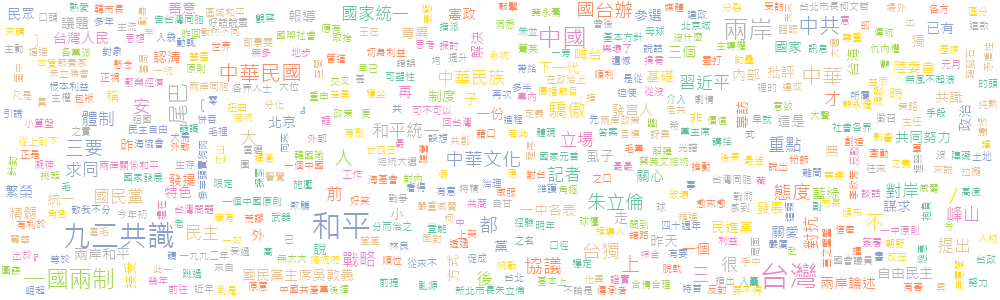

In [55]:
# 九二共識
nt_wc = get_wordcloud_of_keywords('九二共識', contents)
nt_wc.to_file('../politicians/92.png')
nt_wc.to_image()

In [56]:
hot = '九二共識'
news_containing_hot = news_containing_keywords(hot, contents)
hot_dict = get_cutted_dict(news_containing_hot)
first_n_words(hot_dict, 10, 3) # 人名

[('中華民國', 9),
 ('九二共識', 9),
 ('核彈頭', 8),
 ('中國共產黨', 7),
 ('北京當局', 6),
 ('中國政府', 6),
 ('一國兩制', 6),
 ('中華人民共和國', 4),
 ('2019', 4),
 ('轟炸機', 4)]

127


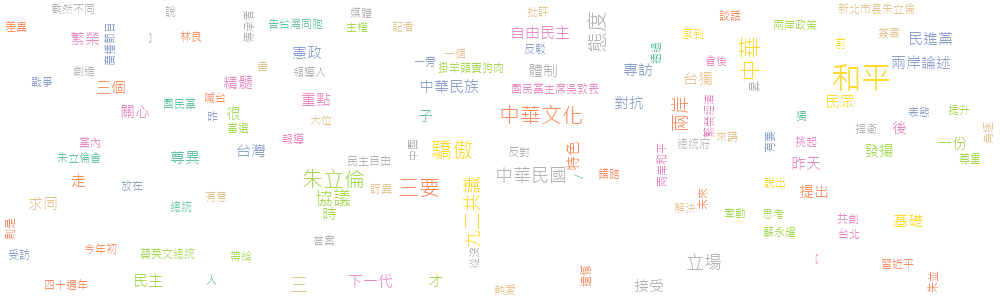

In [57]:
hotwc = get_wordcloud_of_keywords([hot, '蔡英文'], contents[:1000])
hotwc.to_image()

In [58]:
hotP = news_containing_keywords([hot, '蔡英文'], contents)
hotP_dict = get_cutted_dict(hotP)
first_n_words(hotP_dict, 10, 2)

[('和平', 9),
 ('中華', 5),
 ('三要', 4),
 ('態度', 4),
 ('朱立倫', 4),
 ('中華文化', 4),
 ('驕傲', 4),
 ('兩岸', 3),
 ('協議', 3),
 ('中華民國', 3)]

### 定義事件

In [69]:
def merge_one_day_news_dict(one_day_dict, count='wt', divide = 1):
    all_words = set([word for each_dict in one_day_dict for word in each_dict])
    one_day_wf = {}
    for word in all_words:
        one_day_wf[word] = 0
        for news in one_day_dict:
            if count == 'wt':
                one_day_wf[word] += news.get(word, 0)/divide
            if count == 'occur':
                one_day_wf[word] += bool(news.get(word, 0))/divide
    
    return one_day_wf

# 此有ERROR  date_index 必須要Sorted 才能跑下列的 number_of_terms

In [135]:
date_list = [news['date'] for news in data]
all_date = sorted(list(set(date_list)))
aall_date = [date[5:] for date in all_date]
date_index = [date_list.index(each_date) for each_date in all_date]
date_index.append(len(date_list)-1)
date_index = sorted(date_index)
number_of_news = [date_index[i+1] - date_index[i]-1 for i in range(len(date_index)-1)]
number_of_terms = [sum([sum(data[ni]['cutted_dict'].values()) for ni in range(date_index[i], date_index[i+1])]) for i in range(len(date_index)-1)]

50

In [120]:
sorted(date_index)

[0, 7, 14, 21, 28, 36, 49, 49]

In [136]:
# 每日詞數
wn_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict)
#     print(all_date[i])
    wn_by_day[all_date[i]] = current_word_dict

In [142]:
wn_by_day

{'2019-02-27': {'全球': 1.0,
  '諮詢': 1.0,
  '美國政府': 1.0,
  '覬覦': 1.0,
  '交流協會': 2.0,
  '頻密': 1.0,
  '生死存亡': 1.0,
  '領土': 1.0,
  '台灣': 58.0,
  '倒也不是': 1.0,
  '之事': 1.0,
  '帶來': 2.0,
  '以此': 1.0,
  '包容性': 1.0,
  '迫切性': 1.0,
  '機制': 2.0,
  '洋子': 1.0,
  '小國': 1.0,
  '漁權': 1.0,
  '李克強': 1.0,
  '董立文': 3.0,
  '中國': 35.0,
  '延至': 1.0,
  '避談': 1.0,
  '災區': 2.0,
  '車上': 1.0,
  '三': 1.0,
  '經驗': 1.0,
  '狀態': 1.0,
  '但並': 1.0,
  '日本': 24.0,
  '表決': 2.0,
  '站': 2.0,
  '取代': 1.0,
  '揭幕儀式': 1.0,
  '方案': 3.0,
  '出版': 1.0,
  '期間': 2.0,
  '郭育仁': 6.0,
  '武力': 1.0,
  '背書': 1.0,
  '爭議': 1.0,
  '更好': 1.0,
  '說法': 2.0,
  '安納': 2.0,
  '壓力': 1.0,
  '首次': 2.0,
  '刑法': 1.0,
  '時': 5.0,
  '專訪': 6.0,
  '和平統一': 1.0,
  '夥伴': 3.0,
  '每人': 1.0,
  '降低': 1.0,
  '假定': 1.0,
  '不至於': 1.0,
  '承諾': 1.0,
  '賭注': 1.0,
  '毀滅性': 1.0,
  '出爐': 1.0,
  '總統川普': 2.0,
  '調整': 1.0,
  '親自': 1.0,
  '中華人民共和國': 2.0,
  '未有': 1.0,
  '不': 17.0,
  '政治': 3.0,
  '貪污腐敗': 1.0,
  '冷戰': 1.0,
  '並將': 1.0,
  '未': 4.0,
  '見到': 1.0,
  '特有': 1.0,
  '國防': 1.

In [144]:
# 每日詞頻
tf_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, divide=number_of_terms[i])
#     print(all_date[i])
    tf_by_day[all_date[i]] = current_word_dict

In [145]:
tf_by_day

{'2019-02-27': {'全球': 0.0005184033177812338,
  '諮詢': 0.0005184033177812338,
  '美國政府': 0.0005184033177812338,
  '覬覦': 0.0005184033177812338,
  '交流協會': 0.0010368066355624676,
  '頻密': 0.0005184033177812338,
  '生死存亡': 0.0005184033177812338,
  '領土': 0.0005184033177812338,
  '台灣': 0.030067392431311565,
  '倒也不是': 0.0005184033177812338,
  '之事': 0.0005184033177812338,
  '帶來': 0.0010368066355624676,
  '以此': 0.0005184033177812338,
  '包容性': 0.0005184033177812338,
  '迫切性': 0.0005184033177812338,
  '機制': 0.0010368066355624676,
  '洋子': 0.0005184033177812338,
  '小國': 0.0005184033177812338,
  '漁權': 0.0005184033177812338,
  '李克強': 0.0005184033177812338,
  '董立文': 0.0015552099533437014,
  '中國': 0.018144116122343183,
  '延至': 0.0005184033177812338,
  '避談': 0.0005184033177812338,
  '災區': 0.0010368066355624676,
  '車上': 0.0005184033177812338,
  '三': 0.0005184033177812338,
  '經驗': 0.0005184033177812338,
  '狀態': 0.0005184033177812338,
  '但並': 0.0005184033177812338,
  '日本': 0.012441679626749611,
  '表決': 0.0010368

In [138]:
# 每天出現的字
occur_by_day = {}
for i in range(len(date_index)-1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, count='occur', divide=number_of_news[i])
#     print(all_date[i])
    occur_by_day[all_date[i]] = current_word_dict

In [146]:
occur_by_day

{'2019-02-27': {'全球': 0.16666666666666666,
  '諮詢': 0.16666666666666666,
  '美國政府': 0.16666666666666666,
  '覬覦': 0.16666666666666666,
  '交流協會': 0.16666666666666666,
  '頻密': 0.16666666666666666,
  '生死存亡': 0.16666666666666666,
  '領土': 0.16666666666666666,
  '台灣': 0.9999999999999999,
  '倒也不是': 0.16666666666666666,
  '之事': 0.16666666666666666,
  '帶來': 0.16666666666666666,
  '以此': 0.16666666666666666,
  '包容性': 0.16666666666666666,
  '迫切性': 0.16666666666666666,
  '機制': 0.3333333333333333,
  '洋子': 0.16666666666666666,
  '小國': 0.16666666666666666,
  '漁權': 0.16666666666666666,
  '李克強': 0.16666666666666666,
  '董立文': 0.16666666666666666,
  '中國': 0.8333333333333333,
  '延至': 0.16666666666666666,
  '避談': 0.16666666666666666,
  '災區': 0.16666666666666666,
  '車上': 0.16666666666666666,
  '三': 0.16666666666666666,
  '經驗': 0.16666666666666666,
  '狀態': 0.16666666666666666,
  '但並': 0.16666666666666666,
  '日本': 0.8333333333333333,
  '表決': 0.16666666666666666,
  '站': 0.3333333333333333,
  '取代': 0.16666666666666

In [147]:
def first_n_wf_by_day(wf_by_day, n, word_len=2, to=1000):
    return {day: dict(first_n_words(wf_by_day[day], n, word_len=word_len, to=to)) for day in wf_by_day}

In [148]:
first_10_wf_by_day = first_n_wf_by_day(tf_by_day, 10, 2)
first_5_wf_by_day = first_n_wf_by_day(tf_by_day, 5, 2)
df1 = pd.DataFrame(first_10_wf_by_day)
df2 = pd.DataFrame(first_5_wf_by_day)
df = pd.DataFrame(wn_by_day)
df = df.fillna(0)
df_tf = pd.DataFrame(tf_by_day)
df_tf = df_tf.fillna(0)
df_occur = pd.DataFrame(occur_by_day)
df_occur = df_occur.fillna(0)

In [153]:
df.loc['二二八']['2019-02-27':]

2019-02-27     0.0
2019-02-28     0.0
2019-03-01     1.0
2019-03-02    20.0
2019-03-03     4.0
2019-03-04     8.0
Name: 二二八, dtype: float64

IndexError: list index out of range

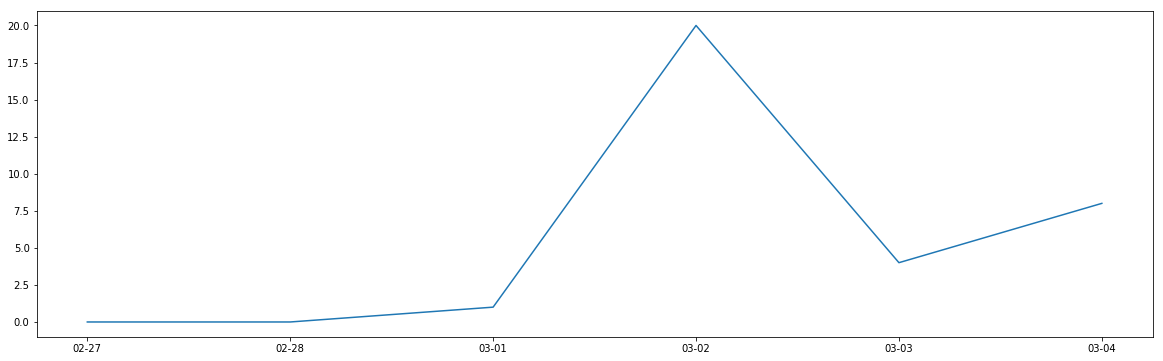

In [154]:
# word times
plt.figure(figsize=(20,6))
plt.plot(aall_date, df.loc['二二八'], label='二二八')
plt.show()

In [186]:
def plot_line_of_word(word, date_from='2019-02-27', date_to='2019-03-04'):
    from_index = df.columns.get_loc(date_from)
    to_index = df.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25
    font_path = 'msjh.ttc'
    font = font_manager.FontProperties(fname='msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    plt.plot(aall_date[from_index:to_index], df.loc[word][date_from:date_to], '-o', label=word)
    plt.legend(prop=font)
    #plt.xticks(list(range(0, date_length, date_int)), [aall_date[from_index:to_index][i] for i in range(0, date_length, date_int)])
    
def plot_tfdf_of_word(word, date_from='2019-02-27', date_to='2019-03-04'):
    from_index = df.columns.get_loc(date_from)
    to_index = df.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25
    font_path = 'msjh.ttc'
    font = font_manager.FontProperties(fname='msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    plt.plot(aall_date[from_index:to_index], 
             df_tf.loc[word][date_from:date_to]*df_occur.loc[word][date_from:date_to], '-o', label=word)
    plt.legend(prop=font)
    #plt.xticks(list(range(0, date_length, date_int)), [aall_date[from_index:to_index][i] for i in range(0, date_length, date_int)])

In [182]:
aall_date

['02-27', '02-28', '03-01', '03-02', '03-03', '03-04']

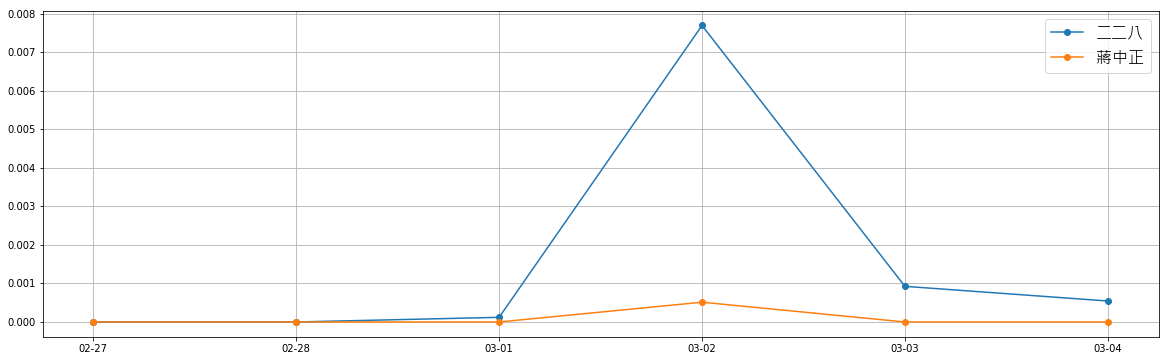

In [188]:
plt.figure(figsize=(20,6))


plot_tfdf_of_word('二二八')
plot_tfdf_of_word('蔣中正')

plt.grid()
plt.show()

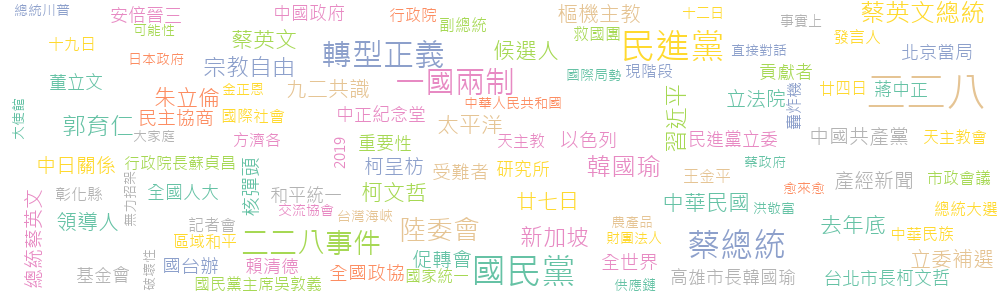

In [189]:
hot3 = first_n_words(cutted_dict, 100, 3)
hot3l = [x[0] for x in hot3]
wc.generate_from_frequencies(dict(hot3)).to_image()

In [221]:
def get_tfdf(word):
    try :
        tfdf = df_occur.loc[word] * df_tf.loc[word]
    except :
        return word
    return tfdf

def get_high_tfdf_date(word):
    try :
        tfdf = df_occur.loc[word] * df_tf.loc[word]
        m = statistics.mean(tfdf)
        s = statistics.stdev(tfdf)
        tfdf_bool = [x > m+s for x in tfdf]
        tfdf_date = {all_date[x[0]]: tfdf[x[0]] for x in list(filter(lambda e: e[1], enumerate(tfdf_bool)))}
    except :
        return  0
    return tfdf_date

# 在此做出修改 避免event中無事件導致ERROR 

def get_high_tfdf_date(word):
    
    try :
        
        tfdf = df_occur.loc[word] * df_tf.loc[word]
        m = statistics.mean(tfdf)
        
        s = statistics.stdev(tfdf)
        tfdf_bool = [x > m+s for x in tfdf]
        
        tfdf_date = {all_date[x[0]]: tfdf[x[0]] for x in list(filter(lambda e: e[1], enumerate(tfdf_bool)))}
    except :
    
        return  0
    return tfdf_date

In [207]:
df_occur.loc[word] * df_tf.loc[word]

NameError: name 'word' is not defined

In [200]:
hot3 = [x[0] for x in first_n_words(cutted_dict, 100, 3)]
print(hot3)
hot3_date = {word: get_high_tfdf_date(word) for word in hot3}
print(hot3_date)

['二二八', '民進黨', '國民黨', '蔡總統', '轉型正義', '一國兩制', '二二八事件', '陸委會', '蔡英文總統', '韓國瑜', '郭育仁', '習近平', '宗教自由', '新加坡', '中華民國', '太平洋', '蔡英文', '去年底', '柯文哲', '候選人', '朱立倫', '領導人', '廿七日', '樞機主教', '立委補選', '九二共識', '核彈頭', '中國共產黨', '立法院', '產經新聞', '中日關係', '總統蔡英文', '促轉會', '柯呈枋', '以色列', '全國政協', '民主協商', '全世界', '受難者', '國台辦', '北京當局', '中國政府', '全國人大', '和平統一', '董立文', '研究所', '貢獻者', '重要性', '民進黨立委', '安倍晉三', '台北市長柯文哲', '高雄市長韓國瑜', '賴清德', '基金會', '蔣中正', '中正紀念堂', '轟炸機', '國際社會', '行政院', '廿四日', '天主教', '方濟各', '副總統', '記者會', '發言人', '國家統一', '現階段', '中華民族', '區域和平', '彰化縣', '總統大選', '天主教會', '國民黨主席吳敦義', '行政院長蘇貞昌', '救國團', '十九日', '市政會議', '王金平', '中華人民共和國', '2019', '破壞性', '可能性', '事實上', '台灣海峽', '大使館', '無力招架', '愈來愈', '日本政府', '直接對話', '十二日', '總統川普', '金正恩', '大家庭', '洪敬富', '供應鏈', '農產品', '國際局勢', '蔡政府', '財團法人', '交流協會']
{'二二八': {'2019-03-02': 0.007692307692307693}, '民進黨': {'2019-03-01': 0.0026474127557160046}, '國民黨': {'2019-03-03': 0.0036985668053629212, '2019-03-04': 0.003807969536243709}, '蔡總統': {'2019-02-27': 0.002073613271124935, '2019-02-28': 0.

In [222]:
def keyword_with_event(keyword):
    news_containing_key = news_containing_keyword(keyword, contents)
    key_dict = get_cutted_dict(news_containing_key)
    key_term = first_n_words(key_dict, 300)
    return list(filter(lambda x: x in hot4, [x[0] for x in key_term]))

def draw_event(event, i):
    event_date = get_high_tfdf_date(event)
    date_index = [all_date.index(x) for x in event_date.keys()]
    plt.scatter(date_index, [i for x in date_index], s=[x*100000 for x in list(event_date.values())])
    
def draw_by_list(tf_list, i):
    plt.scatter(aall_date, [i for x in aall_date], s=[x*10 for x in tf_list])

In [223]:
for i in events :
    print(get_high_tfdf_date(i))
    print(get_tfdf(i))

{'2019-03-03': 0.0004623208506703652}
2019-02-27    0.000000
2019-02-28    0.000000
2019-03-01    0.000000
2019-03-02    0.000000
2019-03-03    0.000462
2019-03-04    0.000340
Name: 九二共識, dtype: float64
{'2019-03-02': 0.0001282051282051282}
2019-02-27    0.000000
2019-02-28    0.000000
2019-03-01    0.000000
2019-03-02    0.000128
2019-03-03    0.000000
2019-03-04    0.000000
Name: 兩岸關係, dtype: float64
{'2019-03-02': 0.0034615384615384616}
2019-02-27    0.000000
2019-02-28    0.000000
2019-03-01    0.000000
2019-03-02    0.003462
2019-03-03    0.000809
2019-03-04    0.000204
Name: 轉型正義, dtype: float64
{'2019-03-01': 0.0012033694344163659}
2019-02-27    0.000000
2019-02-28    0.000000
2019-03-01    0.001203
2019-03-02    0.000000
2019-03-03    0.000000
2019-03-04    0.000136
Name: 立委補選, dtype: float64
{'2019-03-02': 0.0002564102564102564}
2019-02-27    0.000000
2019-02-28    0.000000
2019-03-01    0.000120
2019-03-02    0.000256
2019-03-03    0.000000
2019-03-04    0.000136
Name: 總統大選, 

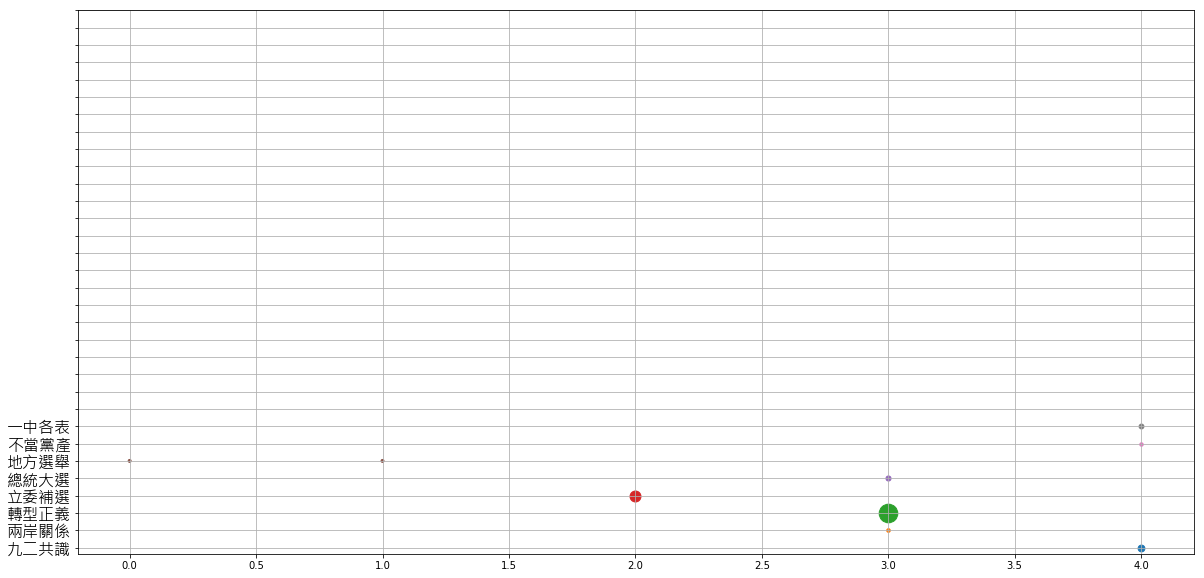

In [224]:
event_high_tfdf_dict = {e: get_high_tfdf_date(e) for e in events}

plt.figure(figsize=(20, 10))
for (i, e) in enumerate(events):
    draw_event(e, i)
# plt.xticks(range(0, 230), all_date)
#plt.xticks(list(range(0, 230, 7)), [aall_date[i] for i in range(0, 230, 7)])
plt.yticks(range(0, 32), events, fontproperties=font)

plt.grid()
plt.show()

In [225]:
# each event with tfdf of related people
event_people_dict = {}
for event in events:
    event_data = data_containing_keyword(event, data)
    # event_data[0]
    name_times_of_date = {}
    for date in all_date:
        oneday_data = list(filter(lambda data: data['date']==date, event_data))
        oneday_dict = [news['cutted_dict'] for news in oneday_data]
        current_word_dict = merge_one_day_news_dict(oneday_dict, 'wt', divide=len(oneday_data))
        possible_name = first_n_words(current_word_dict, 10000, 3, 3)
        name_times_of_date[date]= list(filter(lambda x: x[0] in names, possible_name))

    all_names = set([name for name_list in name_times_of_date.values() for (name, times) in name_list])
    event_people_dict[event] = {name: [dict(name_times_of_date[date]).get(name, 0) for date in all_date] for name in all_names}
    
with open('event_people_dict.json', 'w', encoding='utf-8') as j:
    json.dump(event_people_dict, j)

九二共識


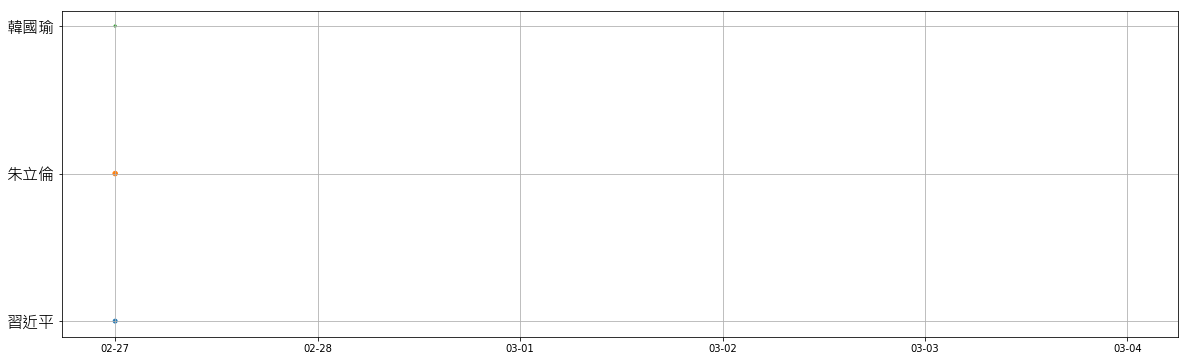

In [228]:
# event_people_dict = dict(sorted(event_people_dict.items(), key=lambda x: sum(x[1]), reverse=True)[:10])

plt.figure(figsize=(20, 6))

event = list(event_people_dict.keys())[0]
print(event)
for (i, people) in enumerate(event_people_dict[event]):
    draw_by_list(event_people_dict[event][people], i)

#plt.xticks(list(range(0, 230, 7)), [aall_date[i] for i in range(0, 230, 7)])
plt.yticks(range(0, len(event_people_dict[event])), [people for people in event_people_dict[event]], fontproperties=font)
    
plt.grid()
plt.show()